# 0) Test model example 

This notebook tests the different models ("hay", "hay_ais") on a simple step stimulus.

In [1]:
import json
import sys
import os
import time
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import MEAutility as mu

import shutil

import multimodalfitting as mf

%matplotlib inline

In [ ]:
# get the absolute path to the current notebook
import os
from pathlib import Path
notebook_dir = Path(os.getcwd())
print("notebook_dir = ", notebook_dir)

# Select the base directory for the model
base_dir = notebook_dir.parent
print("base_dir = ", base_dir)

In [3]:
probe_type = "planar"
model_name = "hay_ais" #"hay_ais" # "hay"
cell_models_folder = base_dir / "cell_models"

model_folder = cell_models_folder / f"{model_name}"

Compile the mod files of the model

In [ ]:
os.chdir(model_folder)
import subprocess
subprocess.run(["nrnivmodl", "mechanisms"], check=True)
os.chdir(notebook_dir)

Add the recordings for the axon intial segment

In [5]:

ais_recordings = mf.utils.get_ais_extra_recordings() # comment this line when using model_name="hay"

In [6]:
# instantiate cell model
cell_opt = mf.create_ground_truth_model(model_name=model_name, 
                                    release=False)
param_names = [p_name for (p_name, p) in cell_opt.params.items() if not p.frozen]

In [7]:
param_names

['g_pas_somatic',
 'g_pas_basal',
 'g_pas_apical',
 'g_pas_axon_initial_segment',
 'decay_CaDynamics_DC0_somatic',
 'gamma_CaDynamics_DC0_somatic',
 'gCa_LVAstbar_Ca_LVAst_somatic',
 'gCa_HVAbar_Ca_HVA2_somatic',
 'gSKv3_1bar_SKv3_1_somatic',
 'gSK_E2bar_SK_E2_somatic',
 'gK_Tstbar_K_Tst_somatic',
 'gK_Pstbar_K_Pst_somatic',
 'gNaTgbar_NaTg_somatic',
 'gamma_CaDynamics_DC0_apical',
 'gSKv3_1bar_SKv3_1_apical',
 'gNaTgbar_NaTg_apical',
 'gCa_LVAstbar_Ca_LVAst_apical',
 'gCa_HVAbar_Ca_HVA2_apical',
 'gamma_CaDynamics_DC0_basal',
 'gCa_LVAstbar_Ca_LVAst_basal',
 'gCa_HVAbar_Ca_HVA2_basal',
 'gCa_LVAstbar_Ca_LVAst_axon_initial_segment',
 'gCa_HVAbar_Ca_HVA2_axon_initial_segment',
 'gSKv3_1bar_SKv3_1_axon_initial_segment',
 'gSK_E2bar_SK_E2_axon_initial_segment',
 'gK_Tstbar_K_Tst_axon_initial_segment',
 'gK_Pstbar_K_Pst_axon_initial_segment',
 'gNap_Et2bar_Nap_Et2_axon_initial_segment',
 'gNa12bar_Na12Hu2009_axon_initial_segment',
 'gNa16bar_Na16Hu2009_axon_initial_segment',
 'gkbar_KdShu2

In [8]:
# define a probe (this can also be defined externally)
probe = mf.define_electrode(probe_type=probe_type)

# instantiate cell model
cell = mf.create_ground_truth_model(model_name=model_name, electrode=probe,
                                    release=True)

# define a test protocol for "hay_ais"
protocols = mf.define_test_step_protocol(step_amplitude=0.5, tot_duration=2000, step_duration=1500, probe=probe,
                                         extra_recordings=dict(TestStep=ais_recordings))
# use this for model_name = "hay"
# protocols = mf.define_test_step_protocol(step_amplitude=0.5, tot_duration=2000, step_duration=1500, probe=probe,
#                                          extra_recordings=None) #dict(TestStep=ais_recordings))
                                         

# instantiate simulator
sim = ephys.simulators.LFPySimulator(
     cvode_active=True, mechanisms_directory=model_folder)


In [9]:
t_start = time.time()
responses = protocols["TestStep"].run(cell, param_values={}, sim=sim)
print(f"Elapsed time: {time.time() - t_start}")

Elapsed time: 6.017273902893066


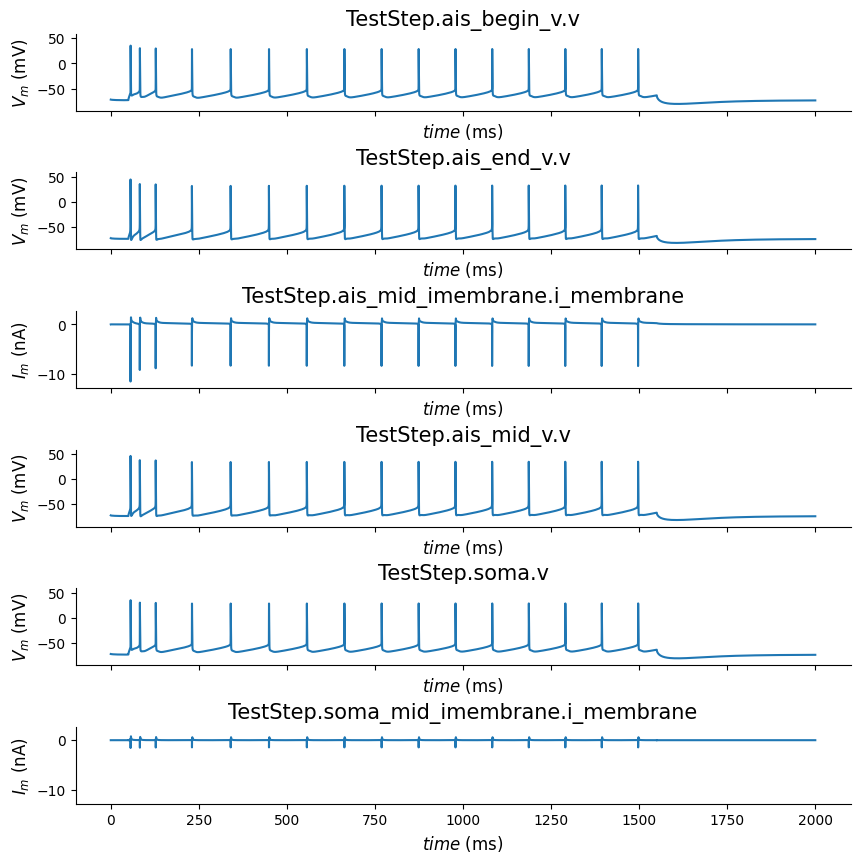

In [10]:
fig = mf.plot_responses(responses, return_fig=True)

In [11]:
eap = mf.calculate_eap(responses, protocols=protocols, protocol_name="TestStep")

In [12]:
max_chan, _ = np.unravel_index(np.argmin(eap), eap.shape)

(-200.0, 800.0)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


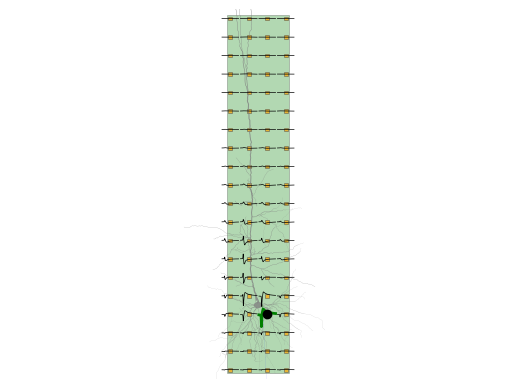

In [13]:
fig_eap, ax_eap = plt.subplots()
ax_eap = mu.plot_probe(probe, ax=ax_eap, type="planar") #, alpha_prb=0.1, alpha_elec=0.3)
ax_eap = mu.plot_mea_recording(eap, probe, colors="k", ax=ax_eap, lw=0.5)
ax_eap = mu.plot_mea_recording(eap, probe, channels=[max_chan], lw=2, colors="g", ax=ax_eap)
ax_eap.plot(*probe.positions[max_chan, :-1], color="k", marker="o")
mf.plot_cell(cell, sim=sim, color_ais="g", color_myelin="b", detailed=True, ax=ax_eap)

ax_eap.set_xlim(-100, 100)
ax_eap.set_ylim(-200, 800)